In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset

In [ ]:
train_dataset = load_dataset('json', data_files='./friends-1-227-Rachel-pair.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='./eval.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
def formatting_func(example):
    text = ""
    for i in example.keys():
        if example[i] is not None:
            text += f"### {example[i]['speaker_name']}: {example[i]['dialogue']}"
            text += "\n"
    text = text[:-1]

    return text

In [ ]:
formatting_func(eval_dataset[1])

'### Chandler: Hey, buddy boy, how’d the audition go?\n### Joey: Not good, no. I didn’t get the part, and I lost my job here, so …\n### Phoebe: Wow! That is a bad audition.\n### Rachel: How-how did you lose your job here?'

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/7243 [00:00<?, ? examples/s]

Map:   0%|          | 0/381 [00:00<?, ? examples/s]

7624


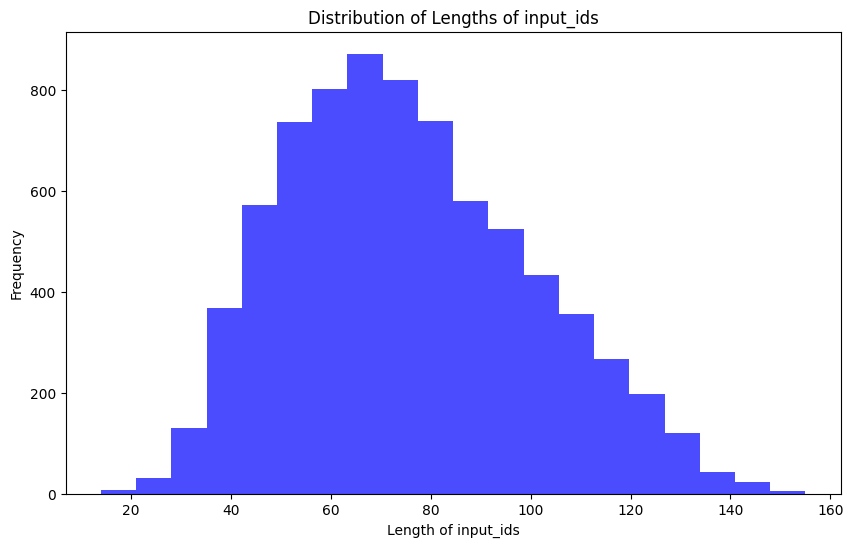

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 256 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/7243 [00:00<?, ? examples/s]

Map:   0%|          | 0/381 [00:00<?, ? examples/s]

7624


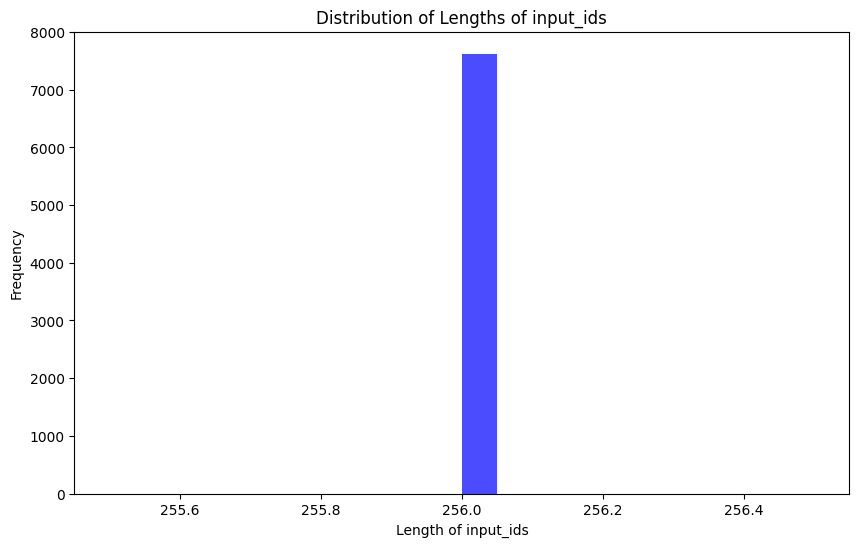

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = base_model_id
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    # bnb_4bit_use_double_quant=True,
    # bnb_4bit_quant_type="nf4",
    # bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
eval_prompt_json = {"0": {"speaker_name": "Ross", "dialogue": "If like the four of us could all y’know, hang out together. Uh, in fact Emily’s coming into town this weekend, why don’t you say we all have dinner? Say, Sunday night?"}, "1": {"speaker_name": "Rachel", "dialogue": "That would be great!"}, "2": {"speaker_name": "Ross", "dialogue": "Yeah, all right, it’s a date."}, "3": {"speaker_name": "Rachel", "dialogue": ""}}
eval_prompt = formatting_func(eval_prompt_json)

print(eval_prompt)

### Ross: If like the four of us could all y’know, hang out together. Uh, in fact Emily’s coming into town this weekend, why don’t you say we all have dinner? Say, Sunday night?
### Rachel: That would be great!
### Ross: Yeah, all right, it’s a date.
### Rachel: 


In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=50, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


### Monica: He probably wants you back because you're right for the job.
### Rachel: Maybe. I-I don't know—Oh God, how could I be so stupid?!
### Joey: Oh Rachel look, don't say that, I think you just need a hug from Joey. Come on. Come on. She's back! Hot girl's back!
### Rachel: ♪♫ You can tell by the way I use my walk, I'm a woman's man no time to talk. ♪♫
### Ross: What are you doing?
### Rachel: ♪��


In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
from peft import prepare_model_for_kbit_training, PeftModel
model = PeftModel.from_pretrained(model, "/content/drive/My Drive/Mistral-5800-8bit")
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
from peft import LoraConfig, get_peft_model, PeftModel

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "rachel-green"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        # resume_from_checkpoint="/content/drive/My Drive/Mistral-1800",
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=50000,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=100,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=100,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
100,2.168600,1.996300
200,2.020800,1.970821
300,1.988100,1.959154
400,1.954400,1.949113
500,1.960300,1.929295
600,1.890700,1.925307
700,1.927400,1.915529
800,1.873400,1.912542
900,1.874500,1.903395
1000,1.894000,1.897863


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during

Step,Training Loss,Validation Loss
100,2.168600,1.996300
200,2.020800,1.970821
300,1.988100,1.959154
400,1.954400,1.949113
500,1.960300,1.929295
600,1.890700,1.925307
700,1.927400,1.915529
800,1.873400,1.912542
900,1.874500,1.903395
1000,1.894000,1.897863


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during

KeyboardInterrupt: 

In [ ]:
eval_prompt_json = {"0": {"speaker_name": "Monica", "dialogue": "He probably wants you back because you're right for the job."}, "1": {"speaker_name": "Rachel", "dialogue": "Maybe. I-I don't know—Oh God, how could I be so stupid?!"}, "2": {"speaker_name": "Joey", "dialogue": "Oh Rachel look, don't say that, I think you just need a hug from Joey. Come on. Come on. She's back! Hot girl's back!"}, "3": {"speaker_name": "Rachel", "dialogue": ""}}

eval_prompt = formatting_func(eval_prompt_json)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=30, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Monica: He probably wants you back because you're right for the job.
### Rachel: Maybe. I-I don't know—Oh God, how could I be so stupid?!
### Joey: Oh Rachel look, don't say that, I think you just need a hug from Joey. Come on. Come on. She's back! Hot girl's back!
### Rachel: ♪♫ You can tell by the way I use my walk, I'm a woman's man no time to talk. ♪


In [ ]:
eval_prompt_json = {"0": {"speaker_name": "Emir", "dialogue": "Hey what do you think about Ross Geller"}, "1": {"speaker_name": "Rachel", "dialogue": ""}}

eval_prompt = formatting_func(eval_prompt_json)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=30, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Emir: Hey what do you think about Ross Geller
### Rachel: ......
### Emir: I'm just kidding, he is the best character on Friends.
### Rachel: Oh my god!


In [ ]:
  !cp -r "./mistral-rachel-green/checkpoint-5000" "/content/drive/MyDrive/Mistral-5000-8bit"

In [ ]:
!cp -r "./mistral-rachel-green/checkpoint-5000" "/content/drive/MyDrive/Mistral-5000-8bit"
!cp -r "./mistral-rachel-green/checkpoint-5100" "/content/drive/MyDrive/Mistral-5100-8bit"
!cp -r "./mistral-rachel-green/checkpoint-5200" "/content/drive/MyDrive/Mistral-5200-8bit"
!cp -r "./mistral-rachel-green/checkpoint-5300" "/content/drive/MyDrive/Mistral-5300-8bit"
!cp -r "./mistral-rachel-green/checkpoint-5400" "/content/drive/MyDrive/Mistral-5000-8bit"
!cp -r "./mistral-rachel-green/checkpoint-5500" "/content/drive/MyDrive/Mistral-5500-8bit"
!cp -r "./mistral-rachel-green/checkpoint-5600" "/content/drive/MyDrive/Mistral-5600-8bit"
!cp -r "./mistral-rachel-green/checkpoint-5700" "/content/drive/MyDrive/Mistral-5700-8bit"
!cp -r "./mistral-rachel-green/checkpoint-5800" "/content/drive/MyDrive/Mistral-5800-8bit"
